# **Instituto Tecnológico y de Estudios superiores de Monterrey**

## Escuela de Ingeniería y Ciencias

### Maestría en inteligencia artificial aplicada

#### Proyecto integrador


**Avance 5**

**Alumnos:**  

Alfonso de Lucas Espinosa - A01795118  
Pablo Andrés Estrada Flores - A01795212



**Introducción**

El objetivo principal de esta etapa fue investigar si la combinación de las predicciones de múltiples modelos base podría conducir a una mejora adicional en el rendimiento, la robustez y la capacidad de generalización del sistema de clasificación. Para ello, se consideraron los modelos individuales de mejor desempeño obtenidos previamente (como LSTM y LightGBM) como componentes fundamentales para estas arquitecturas de ensamble.

Se planificó la construcción y evaluación de diferentes estrategias de ensamble, abarcando tanto enfoques homogéneos como heterogéneos. Esto incluyó la implementación de técnicas como VotingClassifier y StackingClassifier, donde las predicciones de los modelos base se utilizaron para entrenar un meta-aprendiz. Adicionalmente, se contempló la optimización de hiperparámetros para los componentes más relevantes de los ensambles con el fin de maximizar su efectividad.

Finalmente, se llevó a cabo un análisis comparativo exhaustivo, sintetizando los resultados de los modelos de ensamble y los modelos individuales en una tabla que consideró la métrica principal de exactitud (accuracy), así como otras métricas pertinentes (F1-score macro y ponderado) y los tiempos de entrenamiento.


#### 1. Importar librerías

In [ ]:
# Importar librerías y configurar entorno
import numpy as np
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder

# Importar PyTorch para deep learning.
import torch
import torch.nn as nn

#### 2. Configurar dispositivo CUDA

In [ ]:
# Configuración de dispositivo para PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


#### 3. Definir arquitecturas para MLP y LSTM

In [ ]:
# Modelo MLP Profundo
class DeeperMLPClassifier(nn.Module):
    def __init__(self, input_size, fc1_size, fc2_size, fc3_size, num_classes, dropout_rate):
        super(DeeperMLPClassifier, self).__init__()
        # Primera capa oculta: Lineal -> ReLU -> Normalización Batch -> Dropout
        self.fc1 = nn.Linear(input_size, fc1_size)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(fc1_size)
        self.dropout1 = nn.Dropout(dropout_rate)

         # Segunda capa oculta: Lineal -> ReLU -> Normalización Batch -> Dropout
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(fc2_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Tercera capa oculta: Lineal -> ReLU -> Normalización Batch -> Dropout
        self.fc3 = nn.Linear(fc2_size, fc3_size)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(fc3_size)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Capa de salida
        self.fc4 = nn.Linear(fc3_size, num_classes)

    def forward(self, x):
        # Propagación a través de la primera capa oculta
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.bn1(out)
        out = self.dropout1(out)

        # Propagación a través de la segunda capa oculta
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        out = self.dropout2(out)

        # Propagación a través de la tercera capa oculta
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.bn3(out)
        out = self.dropout3(out)

        # Propagación a través de la capa de salida
        out = self.fc4(out)
        return out

# Modelo LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim_lstm, hidden_dim_lstm, num_layers_lstm, num_classes_lstm, dropout_rate_lstm=0.2):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim_lstm = hidden_dim_lstm
        self.num_layers_lstm = num_layers_lstm
        self.lstm = nn.LSTM(input_dim_lstm, hidden_dim_lstm, num_layers_lstm,
                            batch_first=True, dropout=dropout_rate_lstm if num_layers_lstm > 1 else 0)
        self.fc_lstm = nn.Linear(hidden_dim_lstm, num_classes_lstm)
        self.dropout_lstm = nn.Dropout(dropout_rate_lstm)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers_lstm, x.size(0), self.hidden_dim_lstm).to(x.device)
        c0 = torch.zeros(self.num_layers_lstm, x.size(0), self.hidden_dim_lstm).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout_lstm(out[:, -1, :])
        out = self.fc_lstm(out)
        return out

#### 4. Cargar datasets

In [ ]:
# Rutas
# Carga el csv. con los puntos de la mano extraidos de MediaPipe
df_raw = pd.read_csv('hand_landmarks_raw.csv')
X_raw = df_raw.drop('label', axis=1)
y_raw = df_raw['label']

# Carga el csv. con las características de los 37 puntos de la mano
df_37 = pd.read_csv('lsm_kaggle_37_features_escaladas_con_etiquetas.csv')
X_37 = df_37.drop('label', axis=1)
y_37 = df_37['label']

# Carga los datos divididos (X_train, y_train, X_valid, y_valid, X_test, y_test)
X_train_37, X_test_37, y_train_37, y_test_37 = train_test_split(X_37, y_37, test_size=0.2, random_state=42)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

#### 5. Cargar modelos individuales entrenados (con CUDA)

In [ ]:
# --- Hiperparámetros para el modelo MLP
MLP_FC1 = 512
MLP_FC2 = 256
MLP_FC3 = 128
MLP_DROPOUT = 0.2

# --- Hiperparámetros para los modelos ---
input_dim_mlp = 37
input_dim_lstm = 3
hidden_dim_lstm = 128
num_layers_lstm = 2
dropout_rate_lstm = 0.3
output_dim = 21

# --- Carga y configuración del modelo MLP ---
mlp_model = DeeperMLPClassifier(
    input_size=input_dim_mlp,
    fc1_size=MLP_FC1,
    fc2_size=MLP_FC2,
    fc3_size=MLP_FC3,
    num_classes=output_dim,
    dropout_rate=MLP_DROPOUT
)

# Carga los pesos preentrenados del mejor modelo MLP
mlp_model.load_state_dict(torch.load('MLP_Kaggle37Feat_best.pth', map_location=device))
mlp_model.to(device)
mlp_model.eval()

# --- Carga y configuración del modelo LSTM ---
lstm_model = LSTMClassifier(
    input_dim_lstm=input_dim_lstm,
    hidden_dim_lstm=hidden_dim_lstm,
    num_layers_lstm=num_layers_lstm,
    num_classes_lstm=output_dim,
    dropout_rate_lstm=dropout_rate_lstm
)

# Carga los pesos preentrenados del mejor modelo LSTM.
lstm_model.load_state_dict(torch.load('LSTM_KaggleRawLandmarks_best.pth', map_location=device))
lstm_model.to(device)
lstm_model.eval()

# --- Carga de modelos de tradicionales ---
lgbm_model = joblib.load('LightGBM_Kaggle37Feat_best.joblib')
rf_model = joblib.load('RandomForest_Kaggle37Feat_best.joblib')

#### 6. Ensambles homogéneos y heterogéneos

In [ ]:
# --- Definición de Ensambles de Modelos --

# Crea un clasificador por Votación (VotingClassifier).
voting_clf = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('rf', rf_model)
    ],
    voting='soft'
)


# Crea un clasificador por Apilamiento (StackingClassifier).
stacking_clf = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('rf', rf_model)
    ],
    final_estimator=LogisticRegression(max_iter=500)
)


# Crea un clasificador por Bagging (Bootstrap Aggregating).
bagging_clf = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=50, random_state=42),
    n_estimators=10,
    random_state=42
)


# --- Configuración de Búsqueda de Hiperparámetros para Random Forest ---
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Configura GridSearchCV
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=param_grid_rf,
                       cv=3,
                       scoring='accuracy',
                       n_jobs=-1)

#### 7. Entrenar y evaluar modelos de ensamble

In [ ]:
model_results = []

for name, model, X_train, y_train, X_test, y_test in [
    ('VotingClassifier', voting_clf, X_train_37, y_train_37, X_test_37, y_test_37),
    ('StackingClassifier', stacking_clf, X_train_37, y_train_37, X_test_37, y_test_37),
    ('BaggingClassifier', bagging_clf, X_train_37, y_train_37, X_test_37, y_test_37),
    ('RandomForest_GridSearch', grid_rf, X_train_37, y_train_37, X_test_37, y_test_37)
]:
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    best_model = model.best_estimator_ if name == 'RandomForest_GridSearch' else model

    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

 # Agrega los resultados del modelo actual a la lista 'model_results'.
    model_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Training Time (s)': end_time - start_time
    })

In [ ]:
# --- Guardado de Modelos Entrenados ---
joblib.dump(voting_clf, 'VotingClassifier_best.joblib')
joblib.dump(stacking_clf, 'StackingClassifier_best.joblib')
joblib.dump(bagging_clf, 'BaggingClassifier_best.joblib')

# Guardar el mejor RandomForest de GridSearch
if hasattr(grid_rf, 'best_estimator_'):
    joblib.dump(grid_rf.best_estimator_, 'RandomForest_GridSearch_best.joblib')
else:
    joblib.dump(grid_rf, 'RandomForest_GridSearch.joblib')

#### 8. Evaluar MLP y LSTM individualmente

In [ ]:
# Ajustar LabelEncoders con las etiquetas de entrenamiento
label_encoder_37 = LabelEncoder()
label_encoder_37.fit(y_train_37)

label_encoder_raw = LabelEncoder()
label_encoder_raw.fit(y_train_raw)

# MLP
start_time = time.time()
X_test_mlp_tensor = torch.FloatTensor(X_test_37.values).to(device)
mlp_model.eval()
with torch.no_grad():
    outputs_mlp = mlp_model(X_test_mlp_tensor)
    probabilities_mlp = torch.softmax(outputs_mlp, dim=1).cpu().numpy()
    _, predicted_mlp = torch.max(outputs_mlp, 1)
    predicted_labels_mlp = predicted_mlp.cpu().numpy()

predicted_labels_mlp_decoded = label_encoder_37.inverse_transform(predicted_labels_mlp)
end_time = time.time()

acc_mlp = accuracy_score(y_test_37, predicted_labels_mlp_decoded)
report_mlp = classification_report(y_test_37, predicted_labels_mlp_decoded, output_dict=True)

model_results.append({
    'Model': 'MLP',
    'Accuracy': acc_mlp,
    'Precision': report_mlp['weighted avg']['precision'],
    'Recall': report_mlp['weighted avg']['recall'],
    'F1-Score': report_mlp['weighted avg']['f1-score'],
    'Training Time (s)': end_time - start_time
})

# LSTM
start_time = time.time()
landmarks_normalized_for_cnn_lstm = X_test_raw.copy()
wrist_coords_cnn_lstm = landmarks_normalized_for_cnn_lstm.iloc[:, 0:3].values
landmarks_normalized_for_cnn_lstm = landmarks_normalized_for_cnn_lstm.values

for i in range(21):
    start_idx = i * 3
    landmarks_normalized_for_cnn_lstm[:, start_idx:start_idx+3] -= wrist_coords_cnn_lstm

other_landmarks_cnn_lstm = landmarks_normalized_for_cnn_lstm[:, 3:]
other_landmarks_reshaped_cnn_lstm = other_landmarks_cnn_lstm.reshape(landmarks_normalized_for_cnn_lstm.shape[0], 20, 3)
dist_from_wrist_cnn_lstm = np.linalg.norm(other_landmarks_reshaped_cnn_lstm, axis=2)
avg_scale_factor_cnn_lstm = np.mean(dist_from_wrist_cnn_lstm, axis=1) + 1e-6
landmarks_normalized_for_cnn_lstm[:, 3:] /= avg_scale_factor_cnn_lstm[:, np.newaxis]

scaler_raw_landmarks = StandardScaler()
X_test_raw_scaled = scaler_raw_landmarks.fit_transform(landmarks_normalized_for_cnn_lstm)
X_test_lstm_reshaped = X_test_raw_scaled.reshape(-1, 21, 3)

X_test_lstm_tensor = torch.FloatTensor(X_test_lstm_reshaped).to(device)
lstm_model.eval()
with torch.no_grad():
    outputs_lstm = lstm_model(X_test_lstm_tensor)
    probabilities_lstm = torch.softmax(outputs_lstm, dim=1).cpu().numpy()
    _, predicted_lstm = torch.max(outputs_lstm, 1)
    predicted_labels_lstm = predicted_lstm.cpu().numpy()

predicted_labels_lstm_decoded = label_encoder_raw.inverse_transform(predicted_labels_lstm)
end_time = time.time()

acc_lstm = accuracy_score(y_test_raw, predicted_labels_lstm_decoded)
report_lstm = classification_report(y_test_raw, predicted_labels_lstm_decoded, output_dict=True)

model_results.append({
    'Model': 'LSTM',
    'Accuracy': acc_lstm,
    'Precision': report_lstm['weighted avg']['precision'],
    'Recall': report_lstm['weighted avg']['recall'],
    'F1-Score': report_lstm['weighted avg']['f1-score'],
    'Training Time (s)': end_time - start_time
})

#### 9. Tabla comparativa

In [ ]:
# --- Tabla comparativa de los modelos y los tiempos de ejecucion ---
results_df = pd.DataFrame(model_results)
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(results_df)

                     Model  Accuracy  Precision    Recall  F1-Score  \
5                     LSTM  0.997483   0.997485  0.997483  0.997483   
1       StackingClassifier  0.995238   0.995242  0.995238  0.995238   
0         VotingClassifier  0.994767   0.994774  0.994767  0.994768   
3  RandomForest_GridSearch  0.993645   0.993665  0.993645  0.993646   
2        BaggingClassifier  0.992070   0.992099  0.992070  0.992071   
4                      MLP  0.991762   0.991795  0.991762  0.991763   

   Training Time (s)  
5           5.133305  
1         577.548713  
0         129.850082  
3        2928.428181  
2         978.931756  
4           0.033999  


#### 10. Selección final y visualizaciones

Se generan las curvas ROC y Precisión – Recall para las clases con más y menos muestras (0 y 11, respectivamente), así como la matriz de confusión del mejor modelo y su gráfico de errores por clase.


Mejor modelo seleccionado: LSTM


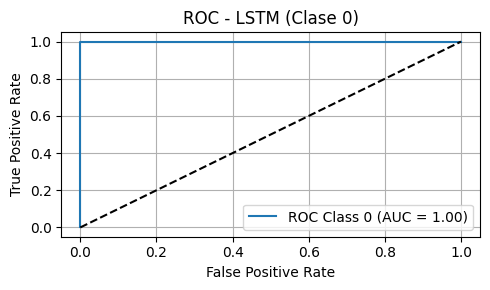

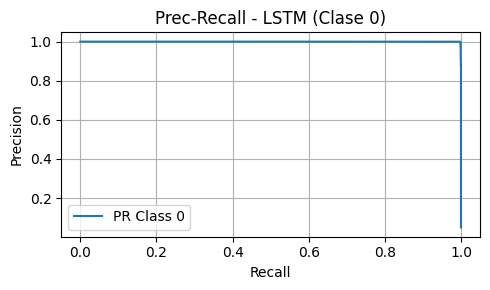

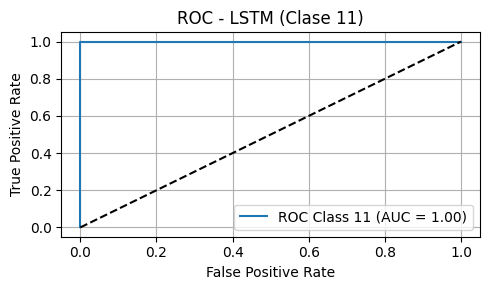

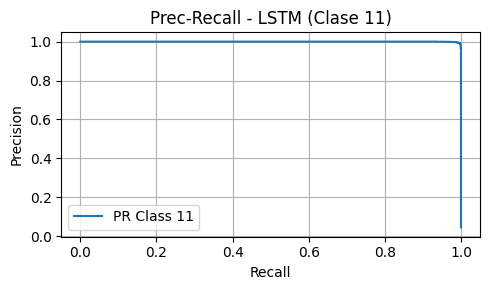

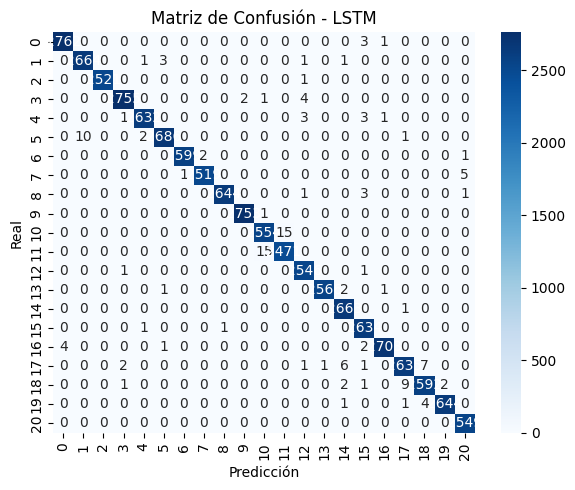

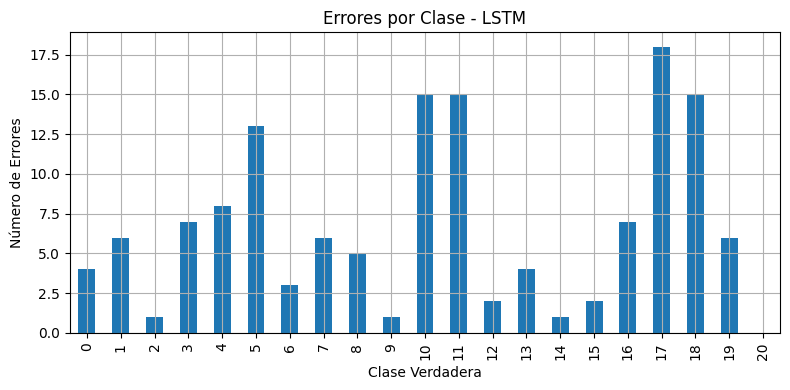

In [ ]:
final_model_name = results_df.iloc[0]['Model']
print(f"\nMejor modelo seleccionado: {final_model_name}")

def plot_roc_pr_curves(y_test_encoded, y_scores, model_name):
    # Seleccionar la clase con más y menos muestras
    class_counts = pd.Series(y_test_encoded).value_counts()
    classes_to_plot = [class_counts.idxmax(), class_counts.idxmin()]
    for i in classes_to_plot:
        if np.sum(y_test_encoded == i) > 0:
            # ROC
            fpr, tpr, _ = roc_curve(y_test_encoded == i, y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(5,3))
            plt.plot(fpr, tpr, label=f'ROC Class {i} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC - {model_name} (Clase {i})')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Prec-Recall
            precision, recall, _ = precision_recall_curve(y_test_encoded == i, y_scores[:, i])
            plt.figure(figsize=(5,3))
            plt.plot(recall, precision, label=f'PR Class {i}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Prec-Recall - {model_name} (Clase {i})')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

if final_model_name in ['VotingClassifier', 'StackingClassifier', 'BaggingClassifier', 'RandomForest_GridSearch']:
    final_model = (
        grid_rf.best_estimator_ if final_model_name == 'RandomForest_GridSearch' else
        voting_clf if final_model_name == 'VotingClassifier' else
        stacking_clf if final_model_name == 'StackingClassifier' else
        bagging_clf
    )
    y_test_encoded = label_encoder_37.transform(y_test_37)
    y_pred_final = final_model.predict(X_test_37)
    y_pred_final_encoded = label_encoder_37.transform(y_pred_final)

    if hasattr(final_model, "predict_proba"):
        y_scores = final_model.predict_proba(X_test_37)
        plot_roc_pr_curves(y_test_encoded, y_scores, final_model_name)

    cm = confusion_matrix(y_test_encoded, y_pred_final_encoded)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {final_model_name}')
    plt.tight_layout()
    plt.show()

    errors = pd.Series(y_test_encoded != y_pred_final_encoded).groupby(y_test_encoded).sum()
    errors.plot(kind='bar', figsize=(8,4), title=f'Errores por Clase - {final_model_name}')
    plt.xlabel('Clase Verdadera')
    plt.ylabel('Número de Errores')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if hasattr(final_model, "feature_importances_"):
        importances = final_model.feature_importances_
        features = X_test_37.columns
        sorted_idx = np.argsort(importances)[::-1]
        plt.figure(figsize=(10,6))
        plt.bar(range(len(importances)), importances[sorted_idx])
        plt.xticks(range(len(importances)), features[sorted_idx], rotation=90)
        plt.title(f'Importancia de Características - {final_model_name}')
        plt.xlabel('Características')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.show()

elif final_model_name == 'MLP':
    y_test_encoded = label_encoder_37.transform(y_test_37)
    y_pred_final_encoded = label_encoder_37.transform(predicted_labels_mlp_decoded)
    plot_roc_pr_curves(y_test_encoded, probabilities_mlp, 'MLP')

    cm = confusion_matrix(y_test_encoded, y_pred_final_encoded)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión - MLP')
    plt.tight_layout()
    plt.show()

    errors = pd.Series(y_test_encoded != y_pred_final_encoded).groupby(y_test_encoded).sum()
    errors.plot(kind='bar', figsize=(8,4), title='Errores por Clase - MLP')
    plt.xlabel('Clase Verdadera')
    plt.ylabel('Número de Errores')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

elif final_model_name == 'LSTM':
    y_test_encoded = label_encoder_raw.transform(y_test_raw)
    y_pred_final_encoded = label_encoder_raw.transform(predicted_labels_lstm_decoded)
    plot_roc_pr_curves(y_test_encoded, probabilities_lstm, 'LSTM')

    cm = confusion_matrix(y_test_encoded, y_pred_final_encoded)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión - LSTM')
    plt.tight_layout()
    plt.show()

    errors = pd.Series(y_test_encoded != y_pred_final_encoded).groupby(y_test_encoded).sum()
    errors.plot(kind='bar', figsize=(8,4), title='Errores por Clase - LSTM')
    plt.xlabel('Clase Verdadera')
    plt.ylabel('Número de Errores')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### 11. Conclusiones



*   El modelo LSTM es la opción más recomendable ya que tiene un acc mayor al 99.7% y además tuvo un tiempo de entrenamiento muy eficiente.
*   Los modelos de ensamble, aunque robustos, implican un mayor coste computacional que en este caso no se traduce en una mejora sustancial sobre el LSTM.
*    Las gráficas demuestran que el modelo LSTM ha aprendido a identificar la "Clase 0" y la "Clase 11" con una precisión y una capacidad de discriminación sobresalientes, prácticamente sin cometer errores para esta categoría.
*    La matriz de confusión del LSTM, ratifica la alta capacidad del modelo para identificar la mayoría de las letras específicas de tu dataset Particularmente, su habilidad para reconocer la Letra A y la Letra N es casi perfecta, validando los análisis gráficos previos.
*   Letra U (Clase 17): Es la letra con el mayor número de errores, aproximadamente 18 errores.
*   La gráfica "Errores por Clase - LSTM" nos da una perspectiva clara de qué letras (clases verdaderas) representaron un mayor desafío para el modelo LSTM. Mientras que letras como C, I, R, O, S y A fueron manejadas con muy alta precisión, otras como U, M, N, V, W y F fueron las que más frecuentemente se clasificaron incorrectamente como otras letra, sin embargo estos errores de reconocimiento son manejables de acuerdo al dataset que estamos trabajando.

